<a href="https://colab.research.google.com/github/reshalfahsi/next-frame-prediction/blob/master/Next_Frame_Prediction_Using_Convolutional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Next-Frame Prediction Using Convolutional LSTM**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 162.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 182.0 MB/s eta 0:00:00


### **Import**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.regression import MeanAbsoluteError

from google.colab.patches import cv2_imshow
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision.transforms import Compose
from torchvision.datasets.utils import download_url

import imageio.v2 as imageio
from moviepy.editor import VideoFileClip

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
FPS            = 2
BATCH_SIZE     = 8
EPOCH          = 16
IMAGE_SIZE     = 32

In [4]:
REDUCE_LR_FACTOR        = 1/2
EARLY_STOPPING_PATIENCE = 1/4
REDUCE_LR_PATIENCE      = 1/16
LEARNING_RATE           = 1/512

In [5]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)

EXPERIMENT_DIR = "experiment/"
DATASET_DIR = "experiment/dataset"
DATASET = "mnist_test_seq.npy"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 309461353


## **Dataset**

### **Download and Prepare**

In [7]:
download_url(
    url="http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
    root="experiment/dataset",
    filename=DATASET,
)

100%|██████████| 819200096/819200096 [02:03<00:00, 6630338.44it/s]


### **Utils**

In [8]:
def _is_tensor_video_clip(clip):
    if not torch.is_tensor(clip):
        raise TypeError("clip should be Tensor. Got %s" % type(clip))

    if not clip.ndimension() == 4:
        raise ValueError("clip should be 4D. Got %dD" % clip.dim())

    return True


def resize(clip, target_size, interpolation_mode):
    assert len(target_size) == 2, "target size should be tuple (height, width)"
    return F.interpolate(clip, size=target_size, mode=interpolation_mode)


def to_tensor(clip):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    Args:
        clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
    Return:
        clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
    """
    _is_tensor_video_clip(clip)
    if not clip.dtype == torch.uint8:
        raise TypeError(
            "clip tensor should have data type uint8. Got %s" % str(clip.dtype)
        )
    return clip.float().permute(3, 0, 1, 2) / 255.0


class ToTensor(object):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    """

    def __init__(self):
        pass

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
        Return:
            clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
        """
        return to_tensor(clip)

    def __repr__(self):
        return self.__class__.__name__


class Resize(object):
    def __init__(self, size, interpolation_mode="bilinear"):
        self.size = size
        self.interpolation_mode = interpolation_mode

    def __call__(self, clip):
        return resize(clip, self.size, self.interpolation_mode)

    def __repr__(self):
        return self.__class__.__name__

In [9]:
TRANSFORM = Compose(
    [
        ToTensor(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
    ]
)

### **Moving MNIST Dataset**

In [10]:
class MovingMNISTDataset(data.Dataset):
    root = DATASET_DIR
    flag = DATASET
    split = None
    train_val_ratio = 0.1
    train_test_ratio = 0.2
    transform = TRANSFORM

    def __init__(self):
        self.dataset = np.expand_dims(
            np.swapaxes(
                np.load(os.path.join(self.root, self.flag)), 0, 1
            ),
            axis=-1,
        )
        dataset_temp = [vid for vid in self.dataset]
        random.shuffle(dataset_temp)
        self.dataset = copy.deepcopy(np.array(dataset_temp))
        del dataset_temp

    def __call__(self, split):
        assert split is not None and split in [
            "train",
            "val",
            "test",
            "inference",
        ], "Please define the dataset split: 'train', 'val', 'test', or 'inference'"

        self.split = split

        print(f"Dataset split: {self.split}")

        len_raw_data = len(self.dataset)

        if self.split == "train":
            self.start = 0
            self.end = int((1 - 0.2) * (1 - 0.1) * len_raw_data)
        elif self.split == "val":
            self.start = int((1 - 0.2) * (1 - 0.1) * len_raw_data)
            self.end = int((1 - 0.2) * len_raw_data)
        elif self.split in ["test", "inference"]:
            self.start = int((1 - 0.2) * len_raw_data)
            self.end = len_raw_data

        if self.split == "inference":
            self.inference_index = random.randint(self.start, self.end - 1)

        return self

    def __len__(self):
        if self.split == "inference":
            return 1
        return len(self.dataset[self.start:self.end])

    def __getitem__(self, idx):
        if self.split != "inference":
            frame = self.dataset[self.start:self.end][idx]
            x = self.transform(
                torch.tensor(
                    frame[0 : frame.shape[0] - 1, :, :, :]
                )
            )
            y = self.transform(
                torch.tensor(
                    frame[1 : frame.shape[0], :, :, :]
                )
            )
            return x, y

        frame = torch.tensor(self.dataset[self.inference_index])
        return self.transform(frame)

### **Load**

In [11]:
MovingMNISTDataset = MovingMNISTDataset()

## **Model**

### **Utils**

In [12]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Convolutional LSTM**

In [13]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size

        self.conv_ii = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hi = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_if = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hf = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_ig = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hg = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_io = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_ho = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state

        i = torch.sigmoid(self.conv_ii(x) + self.conv_hi(h_prev))
        f = torch.sigmoid(self.conv_if(x) + self.conv_hf(h_prev))
        g = F.relu(self.conv_ig(x) + self.conv_hg(h_prev))
        o = torch.sigmoid(self.conv_io(x) + self.conv_ho(h_prev))
        c = f * c_prev + i * g
        h = o * F.relu(c)

        return h, c

In [14]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTM, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        # Single ConvLSTM layer
        self.conv_lstm_cell = ConvLSTMCell(
            self.input_channels, self.hidden_channels, kernel_size, bias
        )

    def forward(self, x):
        batch_size, channels, sequence_length, height, width = x.size()

        # Initialize hidden state and cell state
        h = torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device)

        outputs = list()

        # Process each time step in the sequence
        for t in range(sequence_length):
            h, c = self.conv_lstm_cell(x[:, :, t, :, :], (h, c))
            outputs.append(h)

        outputs = torch.stack(outputs, dim=0).permute(1, 2, 0, 3, 4).contiguous()

        return outputs

In [15]:
class NextFramePredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.convlstm0 = nn.Sequential(
            ConvLSTM(1, 64, 5),
            nn.BatchNorm3d(64),
        )
        self.convlstm1 = nn.Sequential(
            ConvLSTM(64, 64, 3),
            nn.BatchNorm3d(64),
        )
        self.convlstm2 = nn.Sequential(
            ConvLSTM(64, 64, 1),
            nn.BatchNorm3d(64),
        )
        self.final = ConvLSTM(64, 1, 1)

    def forward(self, x):
        x = self.convlstm0(x)
        x = self.convlstm1(x)
        x = self.convlstm2(x)

        return self.final(x)

In [16]:
MODEL = NextFramePredictionModel
MODEL_NAME = MODEL.__name__
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR,f"{MODEL_NAME}_best.ckpt")

### **Wrapper**

In [17]:
class ModelWrapper(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.arch = MODEL()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.automatic_optimization = False

        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

        self.train_loss = list()
        self.val_loss = list()

        self.train_mae_list = list()
        self.val_mae_list = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_mae_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)
        self.train_mae.update(y_hat.view(-1), y.view(-1))
        mae = self.train_mae.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_mae_recorder.update(mae)

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_mae_list.append(self.train_mae_recorder.show().data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_mae.update(y_hat.view(-1), y.view(-1))
            mae = self.val_mae.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_mae", mae, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_mae_recorder.update(mae)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            mae = self.val_mae_recorder.show().data.cpu().numpy()
            sch = self.lr_schedulers()
            sch.step(mae)
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                print(
                    f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_} - Epoch: {self.current_epoch}"
                )
            self.val_mae_list.append(mae)
            self.val_mae_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)
        self.test_mae.update(y_hat.view(-1), y.view(-1))

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_mae",
            self.test_mae.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # MAE
        mae_img_file = f"experiment/training/{MODEL_NAME}_mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list, color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(mae_img_file)
        plt.clf()
        img = cv2.imread(mae_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset('train'),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset('val'),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset('test'),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=REDUCE_LR_FACTOR,
                patience=int(math.ceil(REDUCE_LR_PATIENCE * self.max_epoch)),
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

## **Training**

INFO: Seed set to 309461353
INFO:lightning.fabric.utilities.seed:Seed set to 309461353


NextFramePredictionModel


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params
-------------------------------------------------------
0 | arch      | NextFramePredictionModel | 745 K 
1 | train_mae | MeanAbsoluteError        | 0     
2 | val_mae   | MeanAbsoluteError        | 0     
3 | test_mae  | MeanAbsoluteError        | 0     
-------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Dataset split: val
Dataset split: train


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[NextFramePredictionModel] Learning Rate Changed: 0.001953125 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


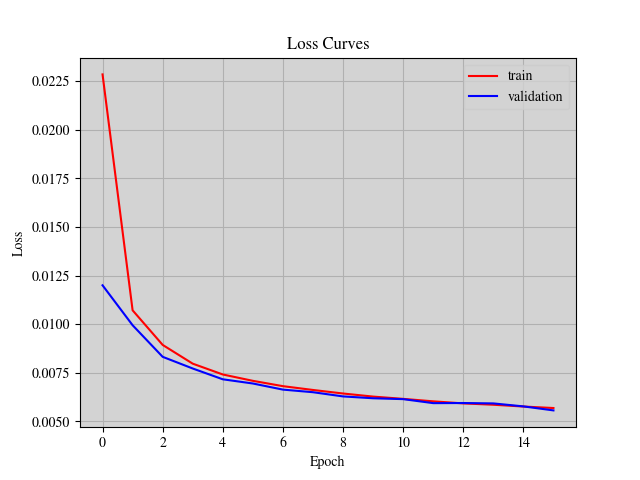

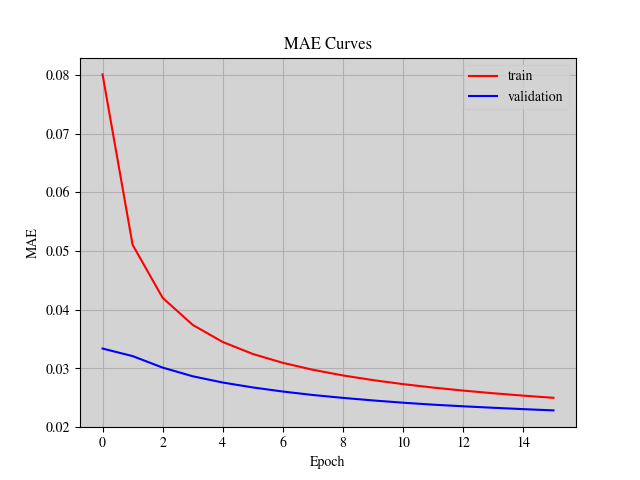

<Figure size 640x480 with 0 Axes>

In [18]:
def _train_loop():
    seed_everything(SEED, workers=True)

    model = ModelWrapper()

    checkpoint = ModelCheckpoint(
        monitor='val_mae',
        dirpath=EXPERIMENT_DIR,
        mode='min',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_mae",
        min_delta=0.00,
        patience=int(EARLY_STOPPING_PATIENCE * EPOCH),
        verbose=False,
        mode="min",
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [19]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ModelWrapper()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/NextFramePredictionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/NextFramePredictionModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/NextFramePredictionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero

Dataset split: test


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.005730812903493643    │
│         test_mae          │   0.019790958613157272    │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Initialization**

In [20]:
model = ModelWrapper.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

ModelWrapper(
  (arch): NextFramePredictionModel(
    (convlstm0): Sequential(
      (0): ConvLSTM(
        (conv_lstm_cell): ConvLSTMCell(
          (conv_ii): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hi): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_if): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hf): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_ig): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hg): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_io): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_ho): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
      )
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convlstm1): Sequential(
      (0): ConvLSTM(
   

### **Prediction**

Dataset split: inference
Dataset split: inference
MoviePy - Building file experiment/result.gif with imageio.


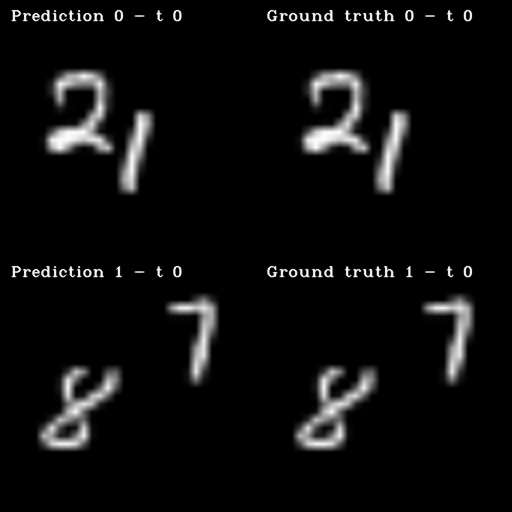

In [42]:
full_video_frames = list()

colors = [(0, 0, 0), (255, 255, 255)]
thickness = [3, 1]
origin = (10, 20)
NUM_SAMPLE = 2


for sample_idx in range(NUM_SAMPLE):
    video_frames = list()
    InferenceDataset = copy.deepcopy(MovingMNISTDataset("inference"))
    InferenceLoader = data.DataLoader(
        dataset=InferenceDataset,
        batch_size=1,
        shuffle=True,
    )
    for idx, batch in enumerate(InferenceLoader):
        frames = batch
        x = frames[:, :, 0 : frames.size(2) - 1, :, :]
        y = frames[:, :, 1 : frames.size(2), :, :]
        y_hat = torch.clamp(
            model(x.to("cpu" if not torch.cuda.is_available() else "cuda")), 0.0, 1.0
        )

        for frame_idx in range(frames.shape[2]):
            if frame_idx < (len(frames)):
                frame_gt = x[:, :, frame_idx, :, :] * 255.0
                frame_gt = frame_gt.squeeze(0).permute(1, 2, 0).cpu().data.numpy()
                frame_gt = frame_gt.astype(np.uint8).copy()
                frame_gt = cv2.resize(frame_gt, (8 * IMAGE_SIZE, 8 * IMAGE_SIZE))

                if frame_idx == 0:
                    frame_pred = frame_gt.copy()
                else:
                    frame_pred = y_hat[:, :, frame_idx - 1, :, :] * 255.0
                    frame_pred = (
                        frame_pred.squeeze(0).permute(1, 2, 0).cpu().data.numpy()
                    )
                    frame_pred = frame_pred.astype(np.uint8).copy()
                    frame_pred = cv2.resize(
                        frame_pred, (8 * IMAGE_SIZE, 8 * IMAGE_SIZE)
                    )
            else:
                frame_gt = y[:, :, frame_idx - 1, :, :] * 255.0
                frame_gt = frame_gt.squeeze(0).permute(1, 2, 0).cpu().data.numpy()
                frame_gt = frame_gt.astype(np.uint8).copy()
                frame_gt = cv2.resize(frame_gt, (8 * IMAGE_SIZE, 8 * IMAGE_SIZE))

                frame_pred = y_hat[:, :, frame_idx - 1, :, :] * 255.0
                frame_pred = frame_pred.squeeze(0).permute(1, 2, 0).cpu().data.numpy()
                frame_pred = frame_pred.astype(np.uint8).copy()
                frame_pred = cv2.resize(frame_pred, (8 * IMAGE_SIZE, 8 * IMAGE_SIZE))

            for color, thick in zip(colors, thickness):
                frame_gt = cv2.putText(
                    frame_gt,
                    f"Ground truth {sample_idx} - t {frame_idx}",
                    origin,
                    cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    0.75,
                    color,
                    thick,
                    cv2.LINE_AA,
                )

                frame_pred = cv2.putText(
                    frame_pred,
                    f"Prediction {sample_idx} - t {frame_idx}",
                    origin,
                    cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    0.75,
                    color,
                    thick,
                    cv2.LINE_AA,
                )

            frame = cv2.hconcat([frame_pred, frame_gt]).copy()
            video_frames.append(frame)
        full_video_frames.append(video_frames)


video_frames = list()
for frame_idx in range(len(full_video_frames[0])):
    video_frame_temp = list()
    for idx in range(len(full_video_frames)):
        video_frame_temp.append(full_video_frames[idx][frame_idx])
    video_frames.append(cv2.vconcat(video_frame_temp).copy())


video_path = "experiment/result.mp4"
imageio.mimwrite(
    video_path,
    video_frames,
    fps=1 / FPS,
    quality=7,
    macro_block_size=None,
)
videoClip = VideoFileClip(video_path)
videoClip.set_fps(1 / FPS)
videoClip.write_gif("experiment/result.gif")
with open("experiment/result.gif", "rb") as f:
    display(Image(data=f.read(), format="gif"))